**Note:** This jupyter notebook contains open source code relating to "Phạm T.-S. and H. Tkalčić, *Observations of up-to-fivefold reverberating waves through the Earth’s center: distinctly anisotropic innermost inner core*, revised, doi:10.21203/rs.3.rs-2026936/v1, 2022.""

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from obspy import read, read_events, read_inventory
import glob
import os
from mpl_toolkits.basemap import Basemap

from obspy.imaging.beachball import beach
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

from obspy.core import Stream
from obspy.geodetics import locations2degrees
from obspy.signal.filter import bandpass

import sys

from obspy.core.event import catalog
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from matplotlib import rcParams
rcParams['font.size'] = 10

## Construction of global stacks of direct wavefield

Raw waveform data are retrieved using obspyDMT program from five data center with following command:

*obspyDMT --datapath Event_data --min_date 2017-01-22 --max_date 2017-01-23 --min_mag 7.0 --net * --cha BHZ --data_source IRIS,ETHZ,INGV,ORFEUS,GFZ --pre_process None --cut_time_phase --preset 500 --offset 7500 --bulk*

Hosseini, K. & Sigloch, K. ObspyDMT: a Python toolbox for retrieving and processing large seismological data sets. Solid Earth 8, 1047–1070 (2017).

### Pre-processing raw waveform data
Pre-processing recipe includes removing of instrumental reponses and resampling to 10 samples per second.

In [2]:
def Remove_Response(wildcast):
    fname_list = glob.glob(wildcast)
    fname_list.sort()

    for fname in fname_list:
        inv_fname = fname.replace('raw', 'resp').replace(os.path.basename(fname), 'STXML.%s' % os.path.basename(fname))
        out_fname = fname.replace('raw', 'processed')
        if os.path.exists(out_fname):continue

        st = read(fname)
        st.merge(fill_value='interpolate')
        st.detrend('linear')
        st.taper(max_percentage=0.005)

        try:
            inv = read_inventory(inv_fname)
            st.remove_response(inventory=inv, pre_filt=(0.005, 0.01, 4, 8))
            if int(st[0].stats.sampling_rate) % 10 == 0:
                st.decimate(int(st[0].stats.sampling_rate/10))
            else:
                st.resample(10)
            st.write(out_fname, format='SAC')
            print (st[0])
        except Exception as ex:
            print (ex)

# if __name__ == '__main__':
#     Remove_Response('Event_data/20151204_222500.a/raw/*.BHZ')

### Map of station having data used
Here we plot the map of event and stations for this event.

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftdata
method to adjust the data to be consistent with the map projection
region (see examples/shiftdata.py).

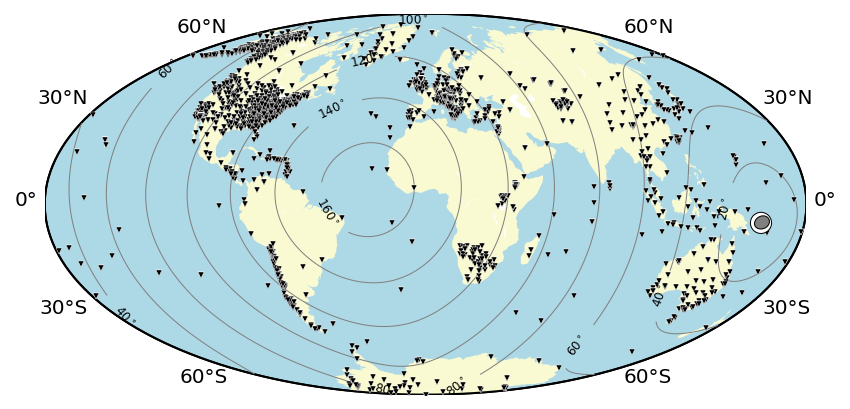

In [3]:
def PlotMap():
    cmap = get_cmap('jet')
    norm = Normalize(vmax=180, vmin=0)

    fig = plt.figure(figsize=(6, 2.95))
    ax = fig.gca()

    m = Basemap(projection='hammer', lon_0=0, resolution='c', ax=ax)
    m.fillcontinents(color='lightgoldenrodyellow')
    m.drawparallels(np.arange(-90.,120.,30.), labels=[True, True, False, False], dashes=(1,0), linewidth=0)
    m.drawmeridians(np.arange(0.,360.,60.), labels=[False, False, True, True], dashes=(1,0), linewidth=0)
    m.drawmapboundary(fill_color='lightblue')

    ## Event location
    event = read_events('web-db-v4.xml')[0]
    evlo, evla = event.origins[0].longitude, event.origins[0].latitude
    xx, yy = m(evlo, evla)

    t = event.focal_mechanisms[0].moment_tensor.tensor
    b = beach(fm=[t.m_rr, t.m_tt, t.m_pp, t.m_rt, t.m_rp, t.m_rp], linewidth=.5, xy=(xx, yy), width=1e6, facecolor='gray')
    ax.add_collection(b)

    ## plot equi-distant contours
    glat = np.arange(-89.5, 90, 1)
    glon = np.arange(-179.5, 180, 1)
    mlat, mlon = np.meshgrid(glat, glon)
    distgrid2source = locations2degrees(evla, evlo, mlat, mlon)
    xx, yy = m(mlon, mlat)
    cs = m.contour(xx, yy, distgrid2source, range(20, 180, 20), linewidths=.5, colors='gray')
    ax.clabel(cs, inline=True, fmt='%d$^\circ$', fontsize=6, colors='k')

    ## Plot stations
    station_fname = 'Event_data/20170122_043022.a/info/station_event'
    lats = np.loadtxt(station_fname, delimiter=',', usecols=[4])
    lons = np.loadtxt(station_fname, delimiter=',', usecols=[5])
    xx, yy = m(lons, lats)
    ax.plot(xx, yy, 'v', ms=3, mec='w', mew=.2, color='k', label='P-wave stations')
    fig.tight_layout()

if __name__ == '__main__':
    PlotMap()

### Construction of global stacks of direct wavefield

The following cell construct the global stack of direct wavefield regarding the 2017 Solomons 

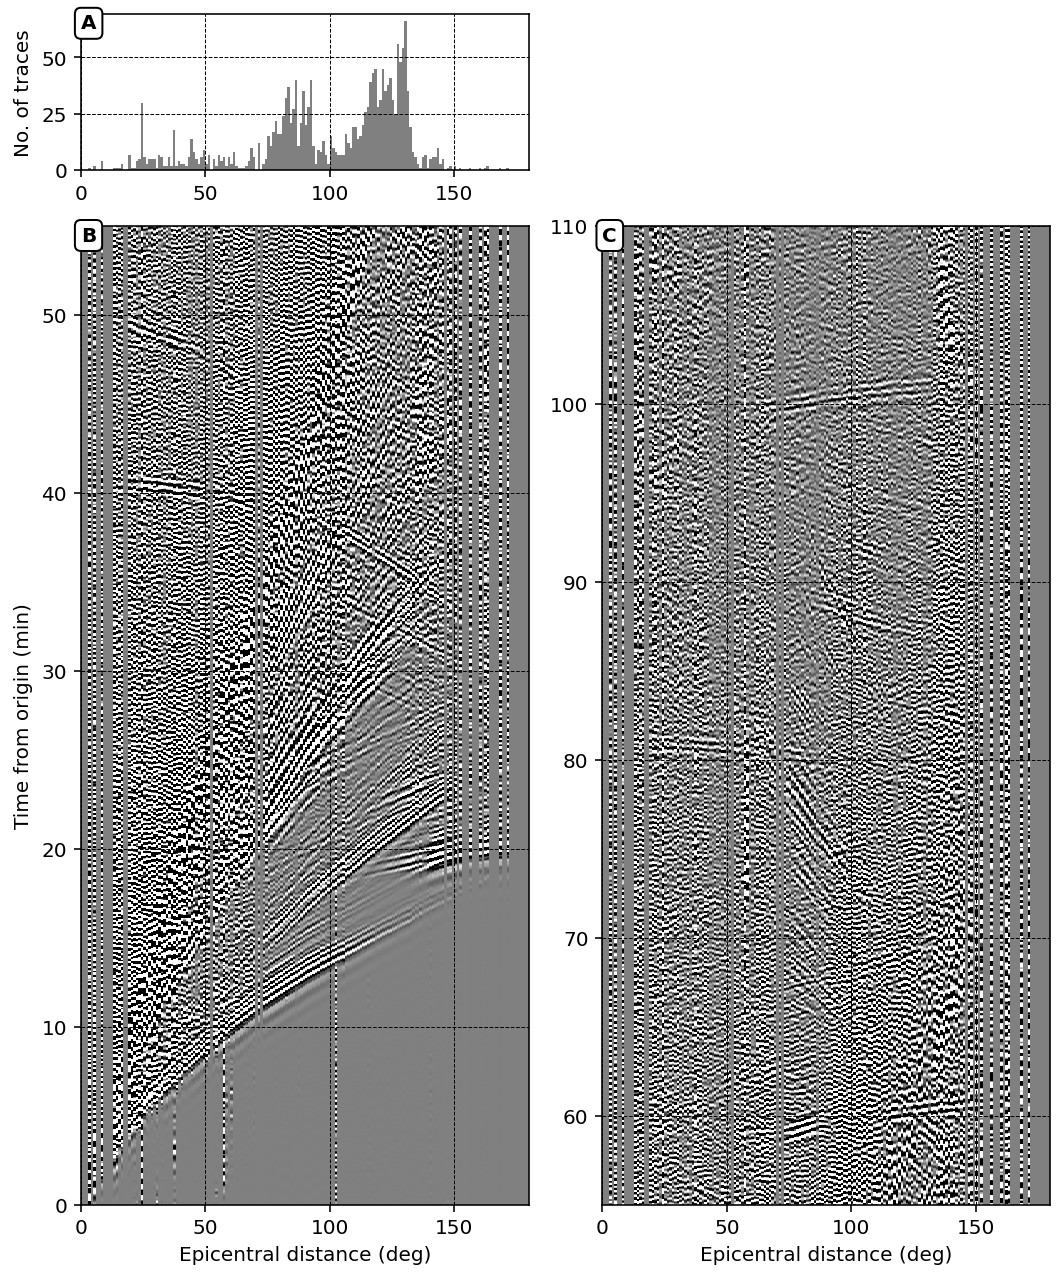

In [4]:
def PlotWavefield():
    isc_orig = read_events('web-db-v4.xml')[0].origins[0]
    orig_time = isc_orig.time
    evla, evlo, evdp = isc_orig.latitude, isc_orig.longitude, isc_orig.depth

    sampling_rate = 10
    bin_size = 1.0
    nbins = int(180 / bin_size)
    npts = int(7400*sampling_rate)
    imag = np.zeros((nbins, npts))

    station_fname = 'Event_data/20170122_043022.a/info/station_event'
    bin_dict = dict()
    with open(station_fname) as fid:
        for line in fid:
            tokens = line.split(',')
            if tokens[3] != 'BHZ': continue

            tr_id = '%s.%s.%s.%s' % tuple(tokens[0:4])
            fname = 'Event_data/20170122_043022.a/processed/%s' % tr_id
            if not os.path.exists(fname): continue

            st = read(fname, format='SAC')
            if st[0].stats.npts < 50000: continue
            if not np.all(np.isfinite(st[0].data)): continue
            st.trim(orig_time, orig_time+7400, pad=True, fill_value=0)

            stla, stlo = float(tokens[4]), float(tokens[5])
            gcarc = locations2degrees(evla, evlo, stla, stlo)

            b = int(np.floor(gcarc/bin_size))
            if b not in bin_dict.keys(): bin_dict[b] = Stream()
            bin_dict[b].extend(st)

    count = np.zeros(nbins, dtype=int)
    for b in bin_dict.keys():
        st = bin_dict[b]
        # st.filter('bandpass', freqmin=0.3, freqmax=1.5, zerophase=False, corners=4)
        # st.filter('bandpass', freqmin=0.01, freqmax=0.10, zerophase=True, corners=4)
        st.filter('bandpass', freqmin=0.02, freqmax=0.067, zerophase=True, corners=4)
        med_value = np.median([np.max(np.abs(tr.data)) for tr in st])

        for tr in st:
            if np.max(np.abs(tr.data)) > 5 * med_value: continue
            count[b] += 1
            imag[b] += tr.data[0:npts]
        imag[b] = imag[b] / count[b] * np.arange(npts)**(1/4)


    ############################ PLOTING SECTION ############################
    fig, ax = plt.subplots(2, 2, figsize=(7.5, 9), gridspec_kw={'height_ratios':(.8, 5)})
    vmax = 5e-5
    tmax = npts/sampling_rate / 60.

    ax[0, 0].bar((np.arange(nbins)+.5) * bin_size, count, color='gray', width=1)
    ax[0, 0].grid(ls='--', color='k', lw=.5)
    ax[0, 0].set_xlim(0, 180)
    ax[0, 0].set_ylabel('No. of traces')
    ax[0, 0].annotate('A', xy=(0., 1.), xycoords='axes fraction', fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    ax[0, 1].set_frame_on(False)

    ax[1, 0].imshow(imag.T, cmap='gray', extent=(0, 180, tmax, 0), vmin=-vmax, vmax=vmax, aspect='auto', interpolation='nearest')
    ax[1, 0].grid(ls='--', color='k', lw=.5)
    ax[1, 0].set_ylim(0, 55)
    ax[1, 0].set_xlim(0, 180)
    ax[1, 0].set_ylabel('Time from origin (min)')
    ax[1, 0].set_xlabel('Epicentral distance (deg)')
    ax[1, 0].annotate('B', xy=(0., 1.), xycoords='axes fraction', fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))

    ax[1, 1].imshow(imag.T, cmap='gray', extent=(0, 180, tmax, 0), vmin=-vmax, vmax=vmax, aspect='auto', interpolation='nearest')
    ax[1, 1].grid(ls='--', color='k', lw=.5)
    ax[1, 1].set_ylim(55, 110)
    # ax[1, 1].set_ylim(55, tmax)
    ax[1, 1].set_xlim(0, 180)
    ax[1, 1].set_xlabel('Epicentral distance (deg)')
    ax[1, 1].annotate('C', xy=(0., 1.), xycoords='axes fraction', fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))

    fig.tight_layout()
    # plt.savefig('SeismicWavefield.pdf', dpi=300)

if __name__ == '__main__':
    PlotWavefield()

## Measurement of differential travel times

### Residual travel time measurements for Mw7.1 Anchorage, 30/11/2018

**STEP 1:** Read waveform data into memory and perform pre-processing.

In [5]:
def MedianFilter(data_stream, factor):
    max_val = np.median([np.max(np.abs(wf.data)) for wf in data_stream])
    tmp_stream = Stream()
    for tr in data_stream:
        if np.max(np.abs(tr.data)) < factor * max_val: 
            tmp_stream.append(tr)
    return tmp_stream

def ReadWaveforms(datapath, bname_list, gcarc, freq, med_thrsh):
    st = Stream()
    ##
    for bname in bname_list:
        fname = os.path.join(path_to_waveforms, bname)
        try:
            tr = read(fname, format='SAC')[0]
        except Exception: continue
        ## not include trace outside of the specified range
        mygcarc = tr.stats.sac.gcarc
        if gcarc != None:
            if mygcarc < gcarc[0] or gcarc[1] < mygcarc: continue
        ## make sure all traces contain finte values
        if np.sum(np.isfinite(tr.data)) < tr.stats.npts: continue
        st.append(tr)
    st.detrend('linear')
    st.detrend('demean')
    if freq != None: st.filter('bandpass', freqmin=freq[0], freqmax=freq[1], zerophase=True, corners=4)

    st = MedianFilter(st, med_thrsh)
    return st


def ApplyCorrection(data_stream, correction_fname):
    ## read correction time as dictionary of trace id
    correct_dict = dict()
    # print (correction_fname)
    fid = open(correction_fname, 'r').readlines()
    for line in fid[1:]:
        tokens = line.split()
        key = tokens[0]
        val = float(tokens[1])
        correct_dict[key] = val

    ## do the correction on each data trace
    for tr in data_stream:
        nshift = int(np.round(-correct_dict[tr.id] / tr.stats.delta))
        tr.data = np.roll(tr.data, nshift)

In [6]:
prefix = 'Event_data'
evid = '20181130_172928.a'
phase1, phase2 = 'PKIKP2', 'PKIKP4'
gcarc = (0, 10)
freq = (0.01, 0.13)
median_factor = 5
ellip_correct = True
mantle_correct = 'DETOX-P3'

##############################################################################
# In this part, I read waveforms from SAC files into streams.
##############################################################################
## readin PKIKP2 waveforms
path_to_waveforms = os.path.join(prefix, evid, phase1)
bname_list = np.loadtxt(path_to_waveforms+'.AVAIL', skiprows=4, usecols=[0], dtype=str)
stream1 = ReadWaveforms(path_to_waveforms, bname_list, gcarc, freq, median_factor)
if ellip_correct == True: 
    ApplyCorrection(stream1, path_to_waveforms + '.' + 'ELLIP')
if mantle_correct != None:
    ApplyCorrection(stream1, path_to_waveforms + '.' + mantle_correct)
## readin PKIKP4 waveforms
path_to_waveforms = os.path.join(prefix, evid, phase2)
stream2 = ReadWaveforms(path_to_waveforms, bname_list, gcarc, freq, median_factor)
if ellip_correct == True:
    ApplyCorrection(stream2, path_to_waveforms + '.' + 'ELLIP')
if mantle_correct != None:
    ApplyCorrection(stream2, path_to_waveforms + '.' + mantle_correct)

##############################################################################
# In this part, I form two streams of identifcal trace id sequences.
##############################################################################
id_list1 = [tr.id for tr in stream1]
id_list2 = [tr.id for tr in stream2]
id_common = list(set(id_list1).intersection(set(id_list2)))
id_common.sort()
common_stream1 = Stream()
common_stream2 = Stream()
for trid in id_common:
    common_stream1.append(stream1[id_list1.index(trid)])
    common_stream2.append(stream2[id_list2.index(trid)])
    assert(common_stream1[-1].id == common_stream2[-1].id)
stream1 = common_stream1
stream2 = common_stream2
print (evid, '- number of %s common stations' % len(stream2))

20181130_172928.a - number of 323 common stations


**STEP 2:** Bootstrap sampling of residual differential travel time between PKIKP2 and PKIKP4 arrivals.

In [7]:
from obspy.taup import TauPyModel
model = TauPyModel('ak135')

npts = 3601
dt = 0.1
ntraces = len(common_stream1)

st_data1 = np.array([tr.data for tr in common_stream1])
st_data2 = np.array([tr.data for tr in common_stream2])
t = np.arange(npts) * dt
t -= .5*np.max(t)
mask = (-30<t)*(t<80)

shifts = []
x1 = np.mean(st_data1, axis=0)
x2 = np.mean(st_data2, axis=0)
x1_max = np.max(np.abs(x1[mask]))
x2_max = np.max(np.abs(x2[mask]))
for nb in range(1000):
    indices = np.random.randint(0, ntraces, ntraces)
    y1 = np.mean(np.array([st_data1[i] for i in indices]), axis=0)
    # ax00.plot(t[mask], y1[mask]/x1_max, lw=.5, color='gray', alpha=0.01)
    y2 = np.mean(np.array([st_data2[i] for i in indices]), axis=0)
    # ax01.plot(t[mask], y2[mask]/x2_max, lw=.5, color='gray', alpha=0.01)
    shifts.append((np.argmax(np.correlate(y1[mask], y2[mask], mode='full')) - len(y1[mask])) * dt)

**STEP 3:** Vizualise the output bootstrap sampling.

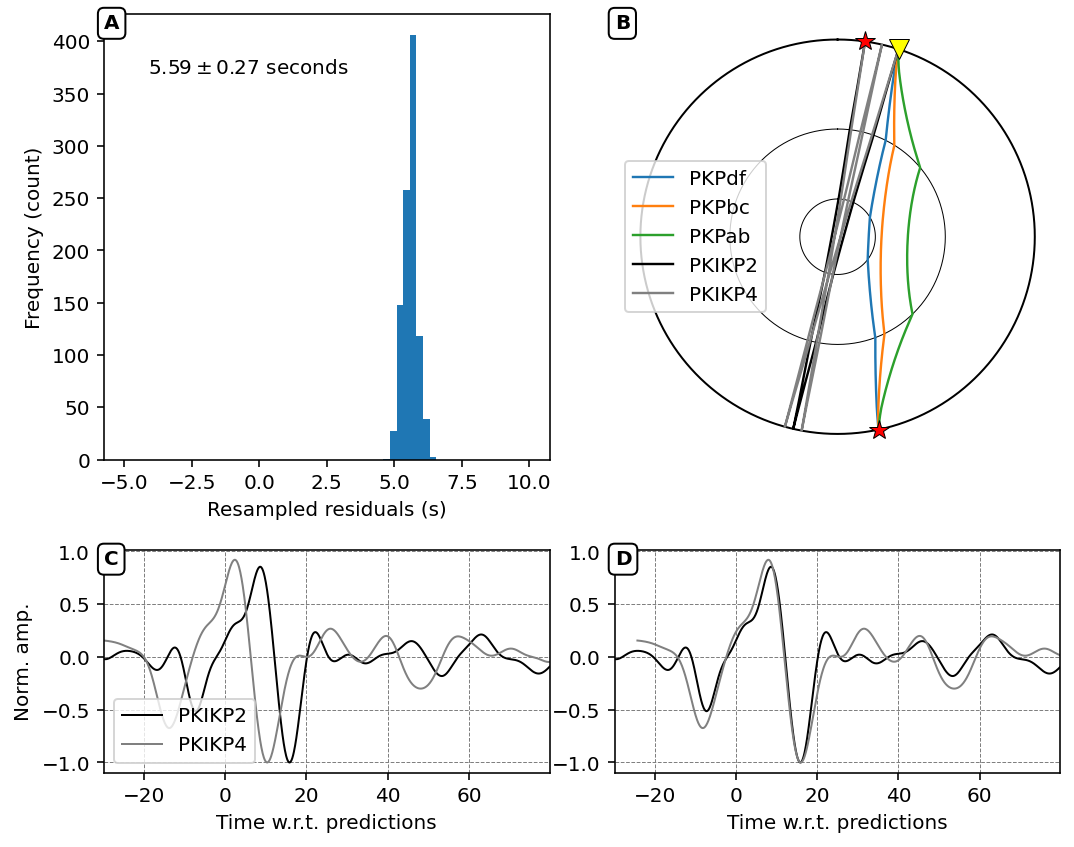

In [8]:
fig = plt.figure(figsize=(7.5, 6.0))
gs = fig.add_gridspec(2, 2, height_ratios=(2, 1))
############## PLOT RAY PATHS ##############
ax_path = fig.add_subplot(gs[0, 1], projection='polar', frame_on=False)
ax_path.set_xticks([])
ax_path.set_yticks([])
ax_path.plot(np.radians(np.arange(361)), np.ones(361)*6371, c='k', lw=1)
ax_path.plot(np.radians(np.arange(361)), np.ones(361)*3480, c='k', lw=.5)
ax_path.plot(np.radians(np.arange(361)), np.ones(361)*1220, c='k', lw=.5)
ax_path.set_ylim(0, 7200)
ax_path.set_theta_zero_location('N')  # theta=0 at the top
ax_path.set_theta_direction(-1)  # theta increasing clockwise
offset = np.pi * .1

## PKP triplication
arvs = model.get_ray_paths(0, 150, ['PKP', 'PKIKP'])
ax_path.plot([p[2]+offset for p in arvs[0].path], [6371-p[3] for p in arvs[0].path], 'C0', lw=1.2, label='PKPdf')
ax_path.plot([p[2]+offset for p in arvs[1].path], [6371-p[3] for p in arvs[1].path], 'C1', lw=1.2, label='PKPbc')
ax_path.plot([p[2]+offset for p in arvs[2].path], [6371-p[3] for p in arvs[2].path], 'C2', lw=1.2, label='PKPab')

## PKIKP multiples
arvs = model.get_ray_paths(0, -10, ['PKIKP'*2, 'PKIKP'*4])
ax_path.plot([p[2]+offset for p in arvs[0].path], [6371-p[3] for p in arvs[0].path], 'k', lw=1.2, label='PKIKP2')
ax_path.plot([p[2]+offset for p in arvs[1].path], [6371-p[3] for p in arvs[1].path], 'gray', lw=1.2, label='PKIKP4')

## Station and event
ax_path.plot(offset, 6371, 'v', c='yellow', ms=10, mew=.5, mec='k')
ax_path.plot([offset-np.radians(10),offset+np.radians(150)], \
    [6371, 6371], '*r', ms=10, mew=.5, mec='k')
ax_path.legend(loc='center left')
ax_path.annotate('B', xy=(0., 1.), xycoords='axes fraction', 
        fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))

############## PLOT WAVEFORM STACKS ##############
ax00 = fig.add_subplot(gs[1, 0])
ax01 = fig.add_subplot(gs[1, 1], sharex=ax00, sharey=ax00)

ax00.plot(t[mask], x1[mask]/x1_max, lw=1, color='k', label='PKIKP2')
ax00.set_ylabel('Norm. amp.')
ax00.plot(t[mask], x2[mask]/x2_max, lw=1, color='gray', label='PKIKP4')
ax00.legend(loc='lower left')
ax00.set_xlabel('Time w.r.t. predictions')

ax01.plot(t[mask], x1[mask]/x1_max, lw=1, color='k', label='PKIKP2')
ax01.plot(t[mask]+np.mean(shifts), x2[mask]/x2_max, lw=1, color='gray', label='PKIKP4')
ax01.set_xlabel('Time w.r.t. predictions')

ax00.grid(ls='--', color='gray', lw=.5)
ax00.annotate('C', xy=(0., 1.), xycoords='axes fraction', 
        fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))
ax01.grid(ls='--', color='gray', lw=.5)
ax01.annotate('D', xy=(0., 1.), xycoords='axes fraction', 
        fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))
ax00.set_xlim(min(t[mask]), max(t[mask]))

############## PLOT DEPTH DEPENDENCE ##############
ax_dept = fig.add_subplot(gs[0, 0])
ax_dept.hist(shifts, bins=61, range=(-5, 10))
ax_dept.annotate('A', xy=(0., 1.), xycoords='axes fraction', 
        fontweight='bold', va='top',  bbox=dict(boxstyle="round", fc="w"))
ax_dept.set_xlabel('Resampled residuals (s)')
ax_dept.set_ylabel('Frequency (count)')
ax_dept.annotate('$%.2f\pm%.2f$ seconds' % (np.mean(shifts), np.std(shifts)),
    xy=(0.1, 0.9), xycoords='axes fraction', va='top')

plt.tight_layout()
plt.show()

## Modelling of inner core's cylindrical anisotropy

Compliation of measurement for 16 events are provided in 'PKIKP_multiple_dataset.csv' file. The following procedure read the input file and fit cylindrical anisotropy models to the observed data.

LLNL-G3Dv3


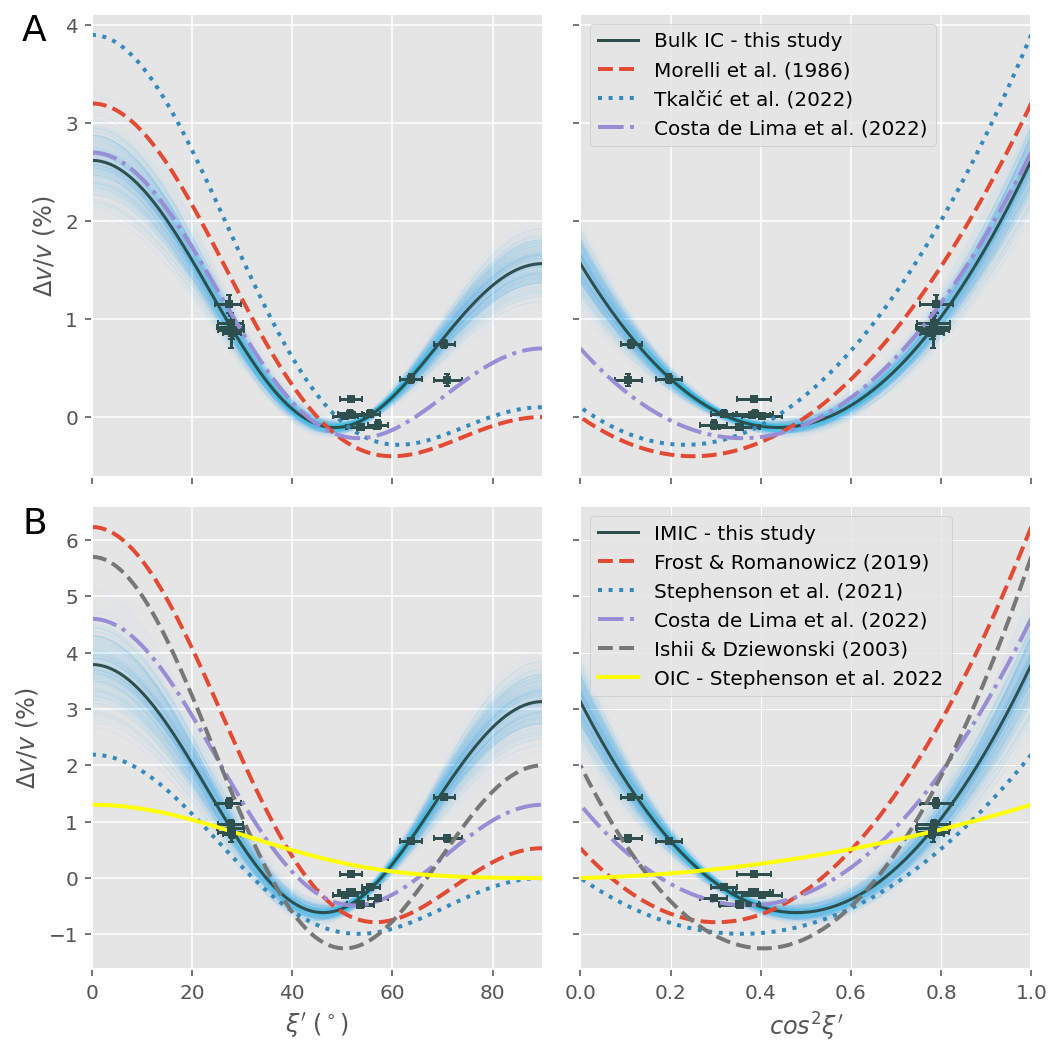

In [9]:
plt.style.use('ggplot')

taup_model = TauPyModel('ak135')
ksi_full = np.linspace(0, 90, 100)
cos2_ksi_full = np.cos(np.radians(ksi_full))**2

from scipy.odr import Model, RealData, ODR
def ani_func(m, cos2_ksi):
    epsilon, sigma, gamma = m
    return epsilon * cos2_ksi + sigma * cos2_ksi * (1 - cos2_ksi) + gamma

def analyse_odr(x, y, sx, sy):
    linear = Model(ani_func)

    mydata = RealData(x, y, sx=sx, sy=sy)
    myodr = ODR(mydata, linear, beta0=[0, 0, 0])
    myoutput = myodr.run()

    return (myoutput.beta, myoutput.cov_beta)


if __name__ == '__main__':
    fig, ax = plt.subplots(2, 2, sharey='row', sharex='col', figsize=(7.5, 7.5))

    ################### THIS STUDY: OBSERVATION AND FITTING CURVES ###################
    multiple_dataset = 'PKIKP_multiple_dataset.csv'
    ic_time = np.loadtxt(multiple_dataset, delimiter=',', usecols=[12])
    cos2_ksi = np.loadtxt(multiple_dataset, delimiter=',', usecols=[10])
    ksi = np.degrees(np.arccos(np.sqrt(cos2_ksi)))
    sigma_cos2_ksi = np.loadtxt(multiple_dataset, delimiter=',', usecols=[11])
    lw_ksi_err = ksi - np.degrees(np.arccos(np.sqrt(cos2_ksi + sigma_cos2_ksi)))
    up_ksi_err = -ksi + np.degrees(np.arccos(np.sqrt(cos2_ksi - sigma_cos2_ksi)))

    # print ('DETOX-P03')
    # dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[8])
    # sigma_dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[9])
    
    # print ('None')
    # dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[2])
    # sigma_dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[3])

    # print ('MIT-P08')
    # dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[4])
    # sigma_dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[5])

    print ('LLNL-G3Dv3')
    dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[6])
    sigma_dt = np.loadtxt(multiple_dataset, delimiter=',', usecols=[7])

    beta, cov_beta = analyse_odr(cos2_ksi, dt/ic_time, sigma_cos2_ksi, sigma_dt/ic_time)
    cov_std = np.linalg.cholesky(cov_beta)
    dv_v_outer = ani_func([1.45, -1.07, 0], cos2_ksi_full)
    
    ##### Fitted line
    for nb in range(500):
        m = beta + np.matmul(cov_std, np.random.normal(0, 1, 3))
        dv_v = 100*ani_func(m, cos2_ksi_full)
        ax[0, 0].plot(ksi_full, dv_v, alpha=.02, color='deepskyblue', lw=.5)
        ax[0, 1].plot(cos2_ksi_full, dv_v, alpha=.02, color='deepskyblue', lw=.5)
        ax[1, 0].plot(ksi_full, 2*dv_v-dv_v_outer, alpha=.02, color='deepskyblue', lw=.5)
        ax[1, 1].plot(cos2_ksi_full, 2*dv_v-dv_v_outer, alpha=.02, color='deepskyblue', lw=.5)
    dv_v = 100*ani_func(beta, cos2_ksi_full)
    ax[0, 0].plot(ksi_full, dv_v, color='darkslategray', label='Bulk IC - this study')
    ax[0, 1].plot(cos2_ksi_full, dv_v, color='darkslategray', label='Bulk IC - this study')
    ax[1, 0].plot(ksi_full, 2*dv_v-dv_v_outer, color='darkslategray', label='IMIC - this study')
    ax[1, 1].plot(cos2_ksi_full, 2*dv_v-dv_v_outer, color='darkslategray', label='IMIC - this study')
    ##### Observation
    ax[0, 0].errorbar(ksi, dt/ic_time*100, yerr=sigma_dt/ic_time*100, xerr=[lw_ksi_err, up_ksi_err],\
        fmt='s', color='darkslategray', ms=3, capsize=1.5, barsabove=False)
    ax[0, 1].errorbar(cos2_ksi, dt/ic_time*100, yerr=sigma_dt/ic_time*100, xerr=sigma_cos2_ksi, \
        fmt='s', color='darkslategray', ms=3, capsize=1.5, barsabove=False)
    dv_v_outer = ani_func([1.45, -1.07, 0], cos2_ksi)
    ax[1, 0].errorbar(ksi, 2*dt/ic_time*100-dv_v_outer, yerr=sigma_dt/ic_time*100, xerr=[lw_ksi_err, up_ksi_err],\
        fmt='s', color='darkslategray', ms=3, capsize=1.5, barsabove=False)
    ax[1, 1].errorbar(cos2_ksi, 2*dt/ic_time*100-dv_v_outer, yerr=sigma_dt/ic_time*100, xerr=sigma_cos2_ksi, \
        fmt='s', color='darkslategray', ms=3, capsize=1.5, barsabove=False)
    
    ################### COMPARISON WITH EXISTING MODELS ###################
    line_style = ['solid', 'dashed', 'dotted', 'dashdot', 'dashed', (0, (5, 10))]
    ## Models for bulk IC
    with open('BulkIC_model_refs.csv') as fid:
        s = 1
        for line in fid:
            if line.startswith('#'): continue
            tokens = line[:line.find('#')].split(',')
            label = tokens[0]
            m0 = np.array(tokens[1:4]).astype(float)
            dv_v =ani_func(m0, cos2_ksi_full)
            ax[0, 0].plot(ksi_full, dv_v, label=label, ls=line_style[s], lw=2)
            ax[0, 1].plot(cos2_ksi_full, dv_v, label=label, ls=line_style[s], lw=2)
            s += 1
    ## Models for IC with IMIC
    with open('IMIC_model_refs.csv') as fid:
        s = 1
        for line in fid:
            if line.startswith('#'): continue
            tokens = line[:line.find('#')].split(',')
            label = tokens[0]
            rIMIC = float(tokens[1])
            m0 = np.array(tokens[2:5]).astype(float)
            m1 = np.array(tokens[5:8]).astype(float)
            dv_v = ani_func(m1, cos2_ksi_full)
            ax[1, 0].plot(ksi_full, dv_v, label=label, ls=line_style[s], lw=2)
            ax[1, 1].plot(cos2_ksi_full, dv_v, label=label, ls=line_style[s], lw=2)
            s += 1
    m1 = (1.3,-1.11,0) ## OIC model from stephenson et al. 2022
    dv_v = ani_func(m1, cos2_ksi_full)
    ax[1, 0].plot(ksi_full, dv_v, label='OIC - Stephenson et al. 2022', ls='-', lw=2, c='yellow')
    ax[1, 1].plot(cos2_ksi_full, dv_v, label='OIC - Stephenson et al. 2022', ls='-', lw=2, c='yellow')

    ##### Figure annotation
    ax[0, 1].legend(loc='upper left')
    ax[1, 1].legend(loc='upper left')
    ax[0, 0].set(ylabel='$\Delta v/v$ (%)')
    ax[0, 0].annotate('A', xy=(-.1, 1), xycoords='axes fraction', va='top', ha='right', fontsize=18)
    ax[1, 0].set(xlim=(0, 90), xlabel='$\\xi\' \; (^\circ)$', ylabel='$\Delta v/v$ (%)')
    ax[1, 0].annotate('B', xy=(-.1, 1), xycoords='axes fraction', va='top', ha='right', fontsize=18)
    ax[1, 1].set(xlim=(0, 1), xlabel='$cos^2\\xi\'$')
    
    plt.grid(ls='-', color='w', lw=.5)
    plt.tight_layout()
    # plt.savefig('Figure3.pdf')
    plt.show()